# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import itertools
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
# set random seed
SEED = 321
np.random.seed(SEED)

sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize']=(12,3)


# Custom Functions

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [3]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [4]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

# Prepare Data for Modeling

In [6]:
#glob all data together
f = "Data/Chicago-Crime*.csv"
crime_data = sorted(glob.glob(f))
crime_data

['Data\\Chicago-Crime_2001.csv',
 'Data\\Chicago-Crime_2002.csv',
 'Data\\Chicago-Crime_2003.csv',
 'Data\\Chicago-Crime_2004.csv',
 'Data\\Chicago-Crime_2005.csv',
 'Data\\Chicago-Crime_2006.csv',
 'Data\\Chicago-Crime_2007.csv',
 'Data\\Chicago-Crime_2008.csv',
 'Data\\Chicago-Crime_2009.csv',
 'Data\\Chicago-Crime_2010.csv',
 'Data\\Chicago-Crime_2011.csv',
 'Data\\Chicago-Crime_2012.csv',
 'Data\\Chicago-Crime_2013.csv',
 'Data\\Chicago-Crime_2014.csv',
 'Data\\Chicago-Crime_2015.csv',
 'Data\\Chicago-Crime_2016.csv',
 'Data\\Chicago-Crime_2017.csv',
 'Data\\Chicago-Crime_2018.csv',
 'Data\\Chicago-Crime_2019.csv',
 'Data\\Chicago-Crime_2020.csv',
 'Data\\Chicago-Crime_2021.csv',
 'Data\\Chicago-Crime_2022.csv']

In [7]:
#create main df
df = pd.concat([pd.read_csv(f, lineterminator='\n') for f in crime_data])
df

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
3,1310717,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
4,1318099,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...,...
238853,12938029,12/31/2022 12:50:00 PM,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
238854,12937822,12/31/2022 12:50:00 PM,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
238855,12937583,12/31/2022 12:52:00 AM,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098
238856,12938420,12/31/2022 12:52:00 PM,ASSAULT,SIMPLE,COMMERCIAL / BUSINESS OFFICE,False,False,1432,14.0,32.0,41.930693,-87.685657


In [8]:
#change datatype of date to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7713109 entries, 0 to 238857
Data columns (total 12 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    int64         
 1   Date                  datetime64[ns]
 2   Primary Type          object        
 3   Description           object        
 4   Location Description  object        
 5   Arrest                bool          
 6   Domestic              bool          
 7   Beat                  int64         
 8   District              float64       
 9   Ward                  float64       
 10  Latitude              float64       
 11  Longitude             float64       
dtypes: bool(2), datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 662.0+ MB


In [9]:
#set primary type as index to create a new dataframe to create new dataframes fopr assault and narcotics
df = df.set_index('Primary Type')
df

,ID,Date,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Primary Type,,,,,,,,,,,
BATTERY,1326041,2001-01-01 01:00:00,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
BATTERY,1319931,2001-01-01 13:00:00,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
GAMBLING,1324743,2001-01-01 13:00:00,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
CRIMINAL DAMAGE,1310717,2001-01-01 01:00:00,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
BATTERY,1318099,2001-01-01 01:00:00,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...
ASSAULT,12938029,2022-12-31 12:50:00,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
ASSAULT,12937822,2022-12-31 12:50:00,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
BATTERY,12937583,2022-12-31 00:52:00,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098


In [21]:
#create new dataframe for assault
assault = df.loc['ASSAULT']
assault

,ID,Date,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Primary Type,,,,,,,,,,,
ASSAULT,1410662,2001-01-01 01:00:00,SIMPLE,RESIDENCE,False,True,223,2.0,NaN,41.803253,-87.608098
ASSAULT,1314713,2001-01-01 13:00:00,AGGRAVATED:KNIFE/CUTTING INSTR,RESIDENCE,True,True,1322,12.0,NaN,41.899521,-87.672220
ASSAULT,1358218,2001-01-01 13:00:00,SIMPLE,APARTMENT,False,False,312,3.0,NaN,41.778744,-87.612135
ASSAULT,1322396,2001-01-01 01:02:29,AGGRAVATED: HANDGUN,RESIDENCE,False,True,611,6.0,NaN,41.750045,-87.667221
ASSAULT,1310096,2001-01-01 01:07:38,AGGRAVATED:KNIFE/CUTTING INSTR,RESIDENCE,True,True,413,4.0,NaN,41.729965,-87.600874
...,...,...,...,...,...,...,...,...,...,...,...
ASSAULT,12937815,2022-12-31 12:38:00,SIMPLE,APARTMENT,False,False,1021,10.0,24.0,41.860229,-87.714022
ASSAULT,12937465,2022-12-31 00:41:00,AGGRAVATED - OTHER DANGEROUS WEAPON,APARTMENT,False,True,921,9.0,15.0,41.817040,-87.684665
ASSAULT,12938029,2022-12-31 12:50:00,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966


In [11]:
#create a new dataframe for narcotics
narcotics = df.loc['NARCOTICS']
narcotics

,ID,Date,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Primary Type,,,,,,,,,,,
NARCOTICS,1325760,2001-01-01 13:00:00,POSS: CANNABIS 30GMS OR LESS,GOVERNMENT BUILDING/PROPERTY,True,False,1033,10.0,NaN,NaN,NaN
NARCOTICS,1327471,2001-01-01 13:10:00,POSS: CRACK,PARKING LOT/GARAGE(NON.RESID.),True,False,2424,24.0,NaN,42.019331,-87.679878
NARCOTICS,1325495,2001-01-01 13:10:00,POSS: CANNABIS 30GMS OR LESS,SIDEWALK,True,False,424,4.0,NaN,41.736585,-87.544309
NARCOTICS,1325471,2001-01-01 01:12:00,POSS: CANNABIS MORE THAN 30GMS,RESIDENCE,True,False,2411,24.0,NaN,42.012293,-87.694610
NARCOTICS,1327596,2001-01-01 13:20:00,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,1414,14.0,NaN,41.921770,-87.700210
...,...,...,...,...,...,...,...,...,...,...,...
NARCOTICS,12937989,2022-12-31 15:37:00,SOLICIT NARCOTICS ON PUBLIC WAY,SIDEWALK,True,False,1122,11.0,28.0,41.880749,-87.723929
NARCOTICS,12938016,2022-12-31 16:20:00,POSSESS - HEROIN (WHITE),SIDEWALK,True,False,1112,11.0,27.0,41.901522,-87.720176
NARCOTICS,12938026,2022-12-31 17:03:00,POSSESS - CANNABIS MORE THAN 30 GRAMS,STREET,True,False,1522,15.0,29.0,41.880951,-87.764879


# Assault Model

In [22]:
#set date as index
assault = assault.set_index('Date')
assault.head()

,ID,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,
2001-01-01 01:00:00,1410662,SIMPLE,RESIDENCE,False,True,223,2.0,NaN,41.803253,-87.608098
2001-01-01 13:00:00,1314713,AGGRAVATED:KNIFE/CUTTING INSTR,RESIDENCE,True,True,1322,12.0,NaN,41.899521,-87.672220
2001-01-01 13:00:00,1358218,SIMPLE,APARTMENT,False,False,312,3.0,NaN,41.778744,-87.612135
2001-01-01 01:02:29,1322396,AGGRAVATED: HANDGUN,RESIDENCE,False,True,611,6.0,NaN,41.750045,-87.667221
2001-01-01 01:07:38,1310096,AGGRAVATED:KNIFE/CUTTING INSTR,RESIDENCE,True,True,413,4.0,NaN,41.729965,-87.600874


In [ ]:
#set frequency to seconds 
assault = assault.asfreq('S')
assault

In [ ]:
#transform the data to obtain a time series of the crime count per month
assault['Month'] = assault.index.month
assault['MonthName'] = assault.index.month_name()
assault.head()

In [18]:
#saving lookup for number vs name
unique_month = assault.drop_duplicates(subset=['Month']).sort_values('Month')
month_lookup =dict(zip(unique_month['Month'],unique_month['MonthName']))
month_lookup

{1: 'January',
 2: 'February',
 3: 'March',
 4: 'April',
 5: 'May',
 6: 'June',
 7: 'July',
 8: 'August',
 9: 'September',
 10: 'October',
 11: 'November',
 12: 'December'}

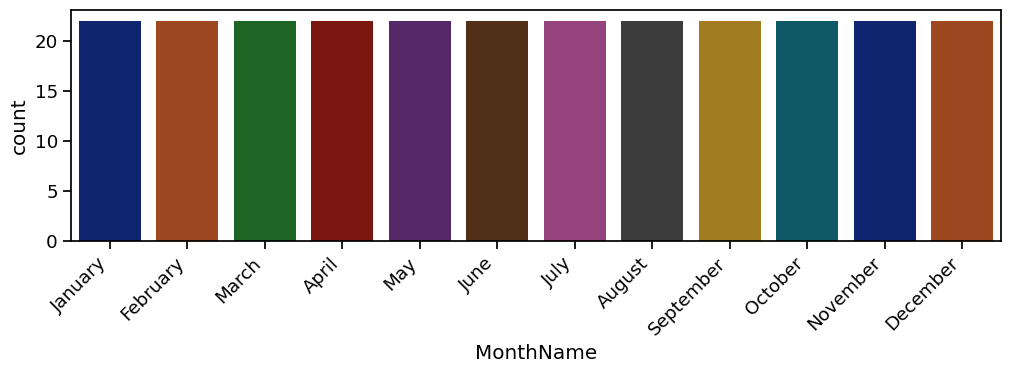

In [19]:
#let's see our counts by month
ax = sns.countplot(data=assault, x='MonthName',palette='dark',order=month_lookup.values());
# Rotate xtick labels and align the text to the bar
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

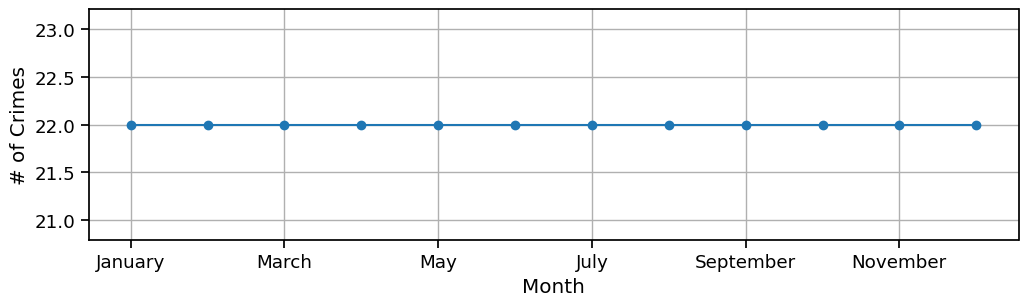

In [20]:
#save month counts
assault_counts = assault['MonthName'].value_counts()[month_lookup.values()]
ax = assault_counts.plot(style='o-',grid=True,
                       ylabel='# of Crimes',
                       xlabel='Month');

In [ ]:
# Apply seasonal decomposition to check for seasonality
decomp = tsa.seasonal_decompose(assault_counts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

# Narcotics Model